# 基于TensorFlow的MNIST手写数字识别
### 作者：张强   
### 微信号：MrZhangQiang2019
### 请关注公众号，免费获得更多的学习教程和资料
![](https://ai-studio-static-online.cdn.bcebos.com/c1ef6aea9943477c83541807e56c5066b0a16810dda843839ebe0edc3968748f)

### <a href="https://blog.csdn.net/u013538542" target="_blank">CSDN博客</a>
### <a href="https://github.com/21-projects-for-deep-learning" target="_blank">Github主页</a>

In [1]:
!pip install tensorflow

In [1]:
import numpy as np
print(np.__version__)

1.15.4


In [2]:
import matplotlib
print(matplotlib.__version__)

2.2.3


In [3]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [5]:
# 查看个人持久化工作区文件
!ls /home/aistudio/data/data65/

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [6]:
!pwd

/home/aistudio


# 下载数据集

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("data/data65/", one_hot=True)

x_train, y_train = mnist.train.images, mnist.train.labels
x_valid, y_valid = mnist.validation.images, mnist.validation.labels
x_test, y_test = mnist.test.images, mnist.test.labels

print("训练集图像大小：{}, 标签大小：{}".format(x_train.shape, y_train.shape))
print("验证集图像大小：{}，标签大小：{}".format(x_valid.shape, y_valid.shape))
print("测试集图像大小：{}，标签大小：{}".format(x_test.shape, y_test.shape))

Extracting data/data65/train-images-idx3-ubyte.gz
Extracting data/data65/train-labels-idx1-ubyte.gz
Extracting data/data65/t10k-images-idx3-ubyte.gz
Extracting data/data65/t10k-labels-idx1-ubyte.gz
训练集图像大小：(55000, 784), 标签大小：(55000, 10)
验证集图像大小：(5000, 784)，标签大小：(5000, 10)
测试集图像大小：(10000, 784)，标签大小：(10000, 10)


# 随机预览几张图像

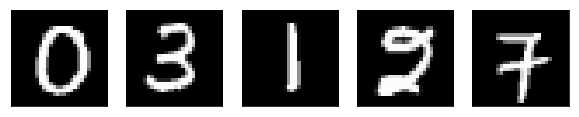

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

fig = plt.figure(figsize=(10, 10))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(x_train[i+10:i+11], (28, 28)), cmap='gray')

# 创建模型

In [6]:
# 超参数准备
img_size = 28 * 28
num_classes = 10
learning_rate = 0.1

# 创建模型
# x表示输入，创建输入占位符，该占位符会在训练时，会对每次迭代的数据进行填充上
x = tf.placeholder(tf.float32, [None, img_size])

# W表示weight，创建权重，初始化时都是为0，它的大小是(图像的向量大小，图像的总类别)
W = tf.Variable(tf.zeros([img_size, num_classes]))

# b表示bias，创建偏移项
b = tf.Variable(tf.zeros([num_classes]))

# y表示计算输出结果，softmax表示激活函数是多类别分类的输出
# 感知器的计算公式就是：(x * W) + b
y = tf.nn.softmax(tf.matmul(x, W) + b)

# 定义输出预测占位符y_
y_ = tf.placeholder(tf.float32, [None, 10])

# 通过激活函数softmax的交叉熵来定义损失函数
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
# 定义梯度下降优化器
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# 比较正确的预测结果
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
# 计算预测准确率
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# 训练模型

In [7]:
import math

epochs = 100
batch_size = 128
iteration = 0
# 定义训练时的检查点
saver = tf.train.Saver()

valid_feed_dict = { x: x_valid, y_: y_valid  }
test_feed_dict = { x: x_test, y_: y_test }
history_train = []
history_valid = []

# 创建一个TensorFlow的会话
with tf.Session() as sess:
  
    # 初始化全局变量
    sess.run(tf.global_variables_initializer())
        
    # 根据每批次训练128个样本，计算出一共需要迭代多少次
    batch_count = int(math.ceil(mnist.train.labels.shape[0] / 128.0))
    
    # 开始迭代训练样本
    for e in range(epochs):
        
        # 每个样本都需要在TensorFlow的会话里进行运算，训练
        for batch_i in range(batch_count):
          
            # 样本的索引，间隔是128个
            batch_start = batch_i * batch_size
            # 取出图像样本
            batch_x = mnist.train.images[batch_start:batch_start+batch_size]
            # 取出图像对应的标签
            batch_y = mnist.train.labels[batch_start:batch_start+batch_size]
            # 训练模型
            loss, acc, _ = sess.run([cost, accuracy, optimizer], feed_dict={x: batch_x, y_: batch_y})
            
            # 每100个批次时输出一次训练损失等日志信息
            if batch_i % 100 == 0:
                print("Epoch: {}/{}".format(e+1, epochs), 
                      "Iteration: {}".format(iteration), 
                      "Train loss: {:.5f}".format(loss),
                      "Train acc: {:.5f}".format(acc))
                history_train.append((iteration, loss, acc))
                
            iteration += 1

            # 每128个样本时，验证一下训练的效果如何，并输出日志信息
            if iteration % batch_size == 0:
                valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict=valid_feed_dict)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Valid Loss: {:.5f}".format(valid_loss),
                      "Valid Acc: {:.5f}".format(valid_acc))
                history_valid.append((iteration, valid_loss, valid_acc))
    
    # 保存训练模型的检查点
    saver.save(sess, "checkpoints/mnist_mlp_tf.ckpt")

Epoch: 1/100 Iteration: 0 Train loss: 2.30259 Train acc: 0.11719
Epoch: 1/100 Iteration: 100 Train loss: 2.08399 Train acc: 0.50781
Epoch: 0/100 Iteration: 128 Valid Loss: 1.97898 Valid Acc: 0.63220
Epoch: 1/100 Iteration: 200 Train loss: 1.93051 Train acc: 0.75000
Epoch: 0/100 Iteration: 256 Valid Loss: 1.82530 Valid Acc: 0.78020
Epoch: 1/100 Iteration: 300 Train loss: 1.77178 Train acc: 0.82812
Epoch: 0/100 Iteration: 384 Valid Loss: 1.76487 Valid Acc: 0.79940
Epoch: 1/100 Iteration: 400 Train loss: 1.82981 Train acc: 0.71875
Epoch: 2/100 Iteration: 430 Train loss: 1.75572 Train acc: 0.81250
Epoch: 1/100 Iteration: 512 Valid Loss: 1.73533 Valid Acc: 0.80820
Epoch: 2/100 Iteration: 530 Train loss: 1.77230 Train acc: 0.80469
Epoch: 2/100 Iteration: 630 Train loss: 1.75993 Train acc: 0.82812
Epoch: 1/100 Iteration: 640 Valid Loss: 1.71724 Valid Acc: 0.81260
Epoch: 2/100 Iteration: 730 Train loss: 1.68420 Train acc: 0.83594
Epoch: 1/100 Iteration: 768 Valid Loss: 1.70423 Valid Acc: 0.818

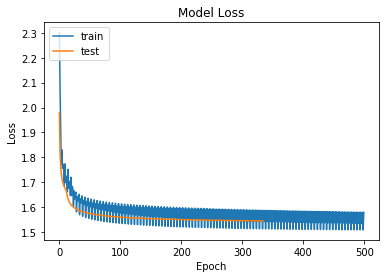

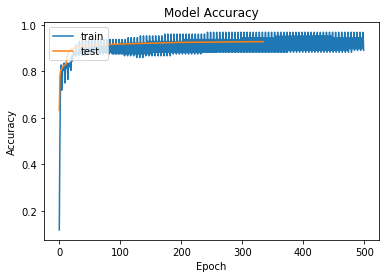

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 绘制训练集和验证集的损失值  
plt.plot(np.array(history_train)[:,1])  
plt.plot(np.array(history_valid)[:,1])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  
 
# 绘制训练集和验证集的精确度  
plt.plot(np.array(history_train)[:,2])  
plt.plot(np.array(history_valid)[:,2])   
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

# 测试模型

In [14]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # 从训练模型的检查点恢复
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # 预测测试集精确度
    test_acc = sess.run(accuracy, feed_dict=test_feed_dict)
    print("Test Accuracy: {}.".format(test_acc))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/mnist_mlp_tf.ckpt
Test Accuracy: 0.925599992275238.


# 随便选择一张测试模型

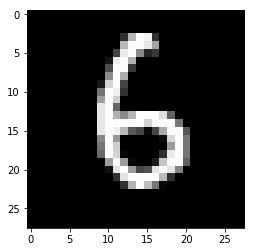

In [15]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 

target_label_index = 21
 
index_21_img = x_test[target_label_index].reshape(28, 28) 
imgplot = plt.imshow(index_21_img, cmap="gray") 
plt.show() 

In [16]:
target_label_arr = y_test[target_label_index] 
target_label = np.argmax(target_label_arr) 
print("索引为21的图像是数字{}。".format(target_label)) 

索引为21的图像是数字6。


In [17]:
checkpoint_file = tf.train.latest_checkpoint("checkpoints")
graph = tf.get_default_graph()

with graph.as_default():
   sess = tf.Session()
   with sess.as_default():
        saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
        saver.restore(sess,checkpoint_file)
        
        # for op in graph.get_operations():
        #       print(op.name)

        softmax_classifer = graph.get_operation_by_name("Softmax").outputs[0]
         
        index_10_img_to_predict = x_test[target_label_index].reshape((1, 784)) 
        predicted_result = sess.run([softmax_classifer], feed_dict={x: index_10_img_to_predict})
        print(predicted_result)
        print("预测的数字是{}。".format(np.argmax(predicted_result)))

INFO:tensorflow:Restoring parameters from checkpoints/mnist_mlp_tf.ckpt
[array([[1.6478752e-07, 1.8716774e-10, 1.4367420e-05, 7.6656121e-08,
        7.3713923e-06, 2.4220503e-04, 9.9968493e-01, 6.0247163e-13,
        5.0681083e-05, 1.7343659e-07]], dtype=float32)]
预测的数字是6。


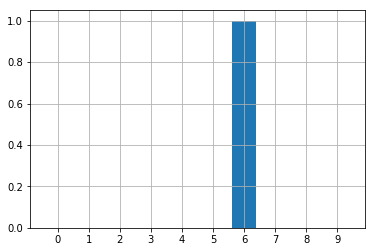

In [80]:
import matplotlib.pyplot as plt 
import numpy as np 
 
x_coordinates = np.arange(predicted_result[0].shape[1]) 
plt.bar(x_coordinates, predicted_result[0][0][:]) 
plt.xticks(x_coordinates, np.arange(10)) 
plt.grid() 
plt.show() 

In [70]:
!ls -lha checkpoints/

total 76K
drwxr-xr-x  2 aistudio users 4.0K May  3 20:29 .
drwxrwxrwx 17 aistudio  1000 4.0K May  3 21:44 ..
-rw-r--r--  1 aistudio users   91 May  3 20:29 checkpoint
-rw-r--r--  1 aistudio users  31K May  3 20:29 mnist_mlp_tf.ckpt.data-00000-of-00001
-rw-r--r--  1 aistudio users  159 May  3 20:29 mnist_mlp_tf.ckpt.index
-rw-r--r--  1 aistudio users  25K May  3 20:29 mnist_mlp_tf.ckpt.meta


### 请关注公众号，免费获得更多的学习教程和资料
![](https://ai-studio-static-online.cdn.bcebos.com/c1ef6aea9943477c83541807e56c5066b0a16810dda843839ebe0edc3968748f)

### <a href="https://blog.csdn.net/u013538542" target="_blank">CSDN博客</a>
### <a href="https://github.com/21-projects-for-deep-learning" target="_blank">Github主页</a>